In [134]:
###################################################################################################
###                             Motif Enrichment                                ###
###################################################################################################

#load libraries
library(tidyverse)
library(devtools)
library(motifmatchr)
library(BiocParallel)
load_all('/home/jpm73279/genome_downloads/BS_genomes/BSgenome.Zm_B73')
library(Matrix)
library(GenomicAlignments)
library(dplyr)
library(universalmotif)  # manipulating motif representations



ℹ Loading BSgenome.Zm_B73


In [135]:
### Load Motifs for Analysis
core_motifs <- read_meme("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/00.data/conserved_consensus_motifs_Fig2B.meme")
de_novo_motifs <- read_meme("/home/jpm73279/genome_downloads/C4_markers/found_motifs/combined_unique_motifs.meme")
ms_de_novo_motifs <- read_meme("/home/jpm73279/genome_downloads/C4_markers/found_motifs/Ms.specific_CGTCGT_motif.comparative.meme")

all_assy_motifs <- c(core_motifs, de_novo_motifs, ms_de_novo_motifs)




all_assy_motifs_converted <- convert_motifs(all_assy_motifs, class = "TFBSTools-PWMatrix")

update_name <- function(pwm) {
    if (!is.null(pwm@name)) {
        pwm@ID <- pwm@name
    }
    return(pwm)
}

library(TFBSTools)
pw_matrix_list_converted <- lapply(all_assy_motifs_converted, update_name)
pw_matrix_list_converted <- lapply(pw_matrix_list_converted, PWMatrixList)
pw_matrix_list_converted <- do.call(c, pw_matrix_list_converted)

In [136]:
marker_file_paths <- c("/home/jpm73279/genome_downloads/C4_markers/Zm.c4_markers.bed")

# Function to read and process the file
process_file <- function(file_path) {
  species <- substr(basename(file_path), 1, 2)
  read_delim(file_path, delim = "\t", col_names = c("chrom", "start", "end", "geneID", "name", "type")) %>% 
    dplyr::select("chrom","start","end","geneID","name","type") %>%
    dplyr::mutate(species = (species))
}

# Apply the function to each file and store results in a list
list_of_dataframes <- lapply(marker_file_paths, process_file)

# Optionally combine all dataframes into one if needed
markers <- bind_rows(list_of_dataframes) %>% 
    dplyr::select(geneID,name,type,species)

Rows: 33 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom, geneID, name, type
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [265]:
###### Define a function to read the data and add columns
read_and_annotate_intersect <- function(file_path, species_abbr) {
  read_delim(file_path, delim = "\t", col_names = FALSE, col_types = "cccccccccc") %>%
    dplyr::mutate(
      species = species_abbr
    )
}

files_conditions <- list(
list(path = "/scratch/jpm73279/comparative_single_cell/07.call.ACRs/10.C4_gene_relationship_only_single_gene/all_acr_intersections/zm.extended_c4_genes.acr_intersection.all.bed", species = "Zm")
)

# Read and annotate each file and store results in a list
annotated_data_list <- lapply(files_conditions, function(condition) {
  read_and_annotate_intersect(condition$path, condition$species)
})

# Combine results
combined_acrs_species <- bind_rows(annotated_data_list)

all_acrs_species_types <- combined_acrs_species %>% 
    ungroup() %>% 
    dplyr::left_join(., markers, by = c("species", "X5" = "name")) %>% 
    dplyr::rename(name = X5) %>% 
    dplyr::rename(enzyme_location = type,
          locus = name,
          acr_name_type = X9) %>% 
    separate(acr_name_type, into = c("acr", "acr_cell_type_specific_class"), sep = ";") %>%
    dplyr::mutate(acr_cell_type_specific_class = case_when(acr_cell_type_specific_class == "bundle_sheath,procambial_meristem" ~ "bundle_sheath",
                                                          acr_cell_type_specific_class == "bundle_sheath,procambium" ~ "bundle_sheath", 
                                                          TRUE ~ acr_cell_type_specific_class)) %>% 
    tidyr::separate(locus, into = c("species_other", "loci"), sep = "__",remove = FALSE) %>%
    tidyr::separate(loci, into = c("gene_family", "number"), sep = "_", remove = FALSE)


filter_acrs_cell_type_specifc <- all_acrs_species_types %>% 
    # Only ACRs around C4 genes we want to keep
    dplyr::filter(is.na(locus) != TRUE) %>% 
    #Filer for only ACRs which are cell-type-specifci
    dplyr::filter(acr_cell_type_specific_class %in% c("broadly_accessible"))



## Generate Granges object from CTS ACRs
filter_acrs_cell_type_specifc_grng <-  filter_acrs_cell_type_specifc%>% 
    dplyr::rename(chr = X6,
                 start = X7,
                 end = X8,
                 acr_id = acr,
                score = acr_cell_type_specific_class)


zm_acrs_cts_gr <- GRanges(filter_acrs_cell_type_specifc_grng, seqinfo=seqinfo(BSgenome.Zm_B73))
names(zm_acrs_cts_gr) <- as.character(zm_acrs_cts_gr)


In [266]:
## Load the Conservation track of all files

process_file <- function(file_info) {
  file_path <- file_info$path
  species <- file_info$species

  # Read and process the file
  read_delim(file_path, 
             col_names = c("qChr", "qStart", "qEnd", "acr_name", "pval", "refFile", "rChr", "rStart", "rEnd", "rName", "rWidth", "strand"),
             col_types = "cccccccccccc") %>%
    dplyr::mutate(species = species) %>%
    tidyr::separate(acr_name, into = c("acr", "acr_cell_type_specific_class", "locus"), sep = ";") %>%
    dplyr::mutate(
      refFile = str_replace(refFile, "\\.all_combined_regions\\.passing_regions\\.blast_passing_regions\\.intersecting_regions\\.ref\\.frac\\.bed", ""),
      refFile = str_replace(refFile, ".*\\.vs\\.", "")
    )
}

# Define file information as a list of lists
file_infos <- list(list(path = "/home/jpm73279/genome_downloads/C4_markers/conservation/Zm.all.ACR_conservation.intersection.bed", species = "Zm")
)

# Process each file
zm_sb_blast_acr_scored_conservation <- bind_rows(lapply(file_infos, process_file)) %>% 
  dplyr::filter(rName != ".") %>% 
  tidyr::separate(rName, into = c("RefFrom", "racr_name", "rcell_type", "gene_family", "gene_family2"), sep = ";", ) %>% 
    dplyr::select(acr, acr_cell_type_specific_class, locus, racr_name, rcell_type , gene_family, rWidth, species, rChr, rStart, rEnd) %>%
    separate(racr_name, into = c("rspecies", "racr"), sep = "_(.*)", extra = "merge", remove = FALSE) %>% 
    dplyr::mutate(acr_cell_type_specific_class = case_when(acr_cell_type_specific_class == "bundle_sheath,procambial_meristem" ~ "bundle_sheath",
                                                          acr_cell_type_specific_class == "bundle_sheath,procambium" ~ "bundle_sheath", 
                                                          TRUE ~ acr_cell_type_specific_class)) %>% 
    dplyr::mutate(qacr = str_c(species, acr, sep = "_"))


#Isoalte the Regions which are conserved, and then merge these regions in a gRanges object
convert_to_conservation_granges <- zm_sb_blast_acr_scored_conservation %>% 
    dplyr::rename(chr = rChr,
                 start = rStart,
                 end = rEnd,
                 acr_id = acr,
                score = rWidth) %>% 
    #filter for only the ACRs which are CTS from the above analysis
    dplyr::filter(acr_id %in% filter_acrs_cell_type_specifc$acr)

conservd_acr_regions <- GRanges(convert_to_conservation_granges, seqinfo=seqinfo(BSgenome.Zm_B73))

# Combine the reduced GRanges objects back into one GRanges object
conservd_acr_regions_merrged <- reduce(conservd_acr_regions)
#conservd_acr_regions_merrged$conserved_regions <- "Conserved"  # Replace with appropriate value


In [267]:
split_granges <- split(conservd_acr_regions, conservd_acr_regions$acr_id)

# Apply 'reduce' to each subset
reduced_granges_list <- lapply(split_granges, reduce)

In [268]:
conservd_acr_regions_merrged <- GRanges()

# Loop over the list and assign names as metadata
for (name in names(reduced_granges_list)) {
  gr <- reduced_granges_list[[name]]
  mcols(gr)$acr_ID <- name
  conservd_acr_regions_merrged <- c(conservd_acr_regions_merrged, gr)
}

# Now 'combined_granges' is a single GRanges object with 'acr_ID' metadata
# View the combined GRanges object

### Annotate the conserved regions
# Find overlaps between the two GRanges objects
overlaps <- findOverlaps(conservd_acr_regions_merrged, zm_acrs_cts_gr)
# Transfer metadata from non_conserved_acr_regions to conservd_acr_regions_merrged
mcols(conservd_acr_regions_merrged) <- mcols(zm_acrs_cts_gr)[subjectHits(overlaps), ]
conservd_acr_regions_merrged$conserved_regions <- "conserved"


ERROR: Error in normarg_mcols(value, class(x), length(x)): trying to set metadata columns of length 171 on an object of length 168


In [260]:
## Annotate the Non-Conserved Regulatory Regions
results <- GenomicRanges::setdiff(zm_acrs_cts_gr, conservd_acr_regions_merrged, ignore.strand = TRUE)
revmap <- findOverlaps(results, zm_acrs_cts_gr, select="arbitrary")
mcols(results) <- mcols(zm_acrs_cts_gr)[revmap, , drop=FALSE]

non_conserved_acr_regions <- results
non_conserved_acr_regions$conserved_regions <- "non_conserved"

In [161]:
#### 
### Quicky Sanity Check
###
# library(plyranges)
# test_resulting <- results %>% 
#     dplyr::filter(gene_family == "PEPC")


# df <- data.frame(seqnames=seqnames(test_resulting),
#   starts=start(test_resulting)-1,
#   ends=end(test_resulting),
#   names=c(rep(".", length(test_resulting))),
#   scores=c(rep(".", length(test_resulting))),
#   strands=strand(test_resulting))

# write.table(df, file="/home/jpm73279/delete_me/non_conserved.bed", quote=F, sep="\t", row.names=F, col.names=F)



# df2 <- data.frame(seqnames=seqnames(conservd_acr_regions_merrged),
#   starts=start(conservd_acr_regions_merrged)-1,
#   ends=end(conservd_acr_regions_merrged),
#   names=c(rep(".", length(conservd_acr_regions_merrged))),
#   scores=c(rep(".", length(conservd_acr_regions_merrged))),
#   strands=strand(conservd_acr_regions_merrged))

# write.table(df2, file="/home/jpm73279/delete_me/conserved.bed", quote=F, sep="\t", row.names=F, col.names=F)


In [261]:
merged_regions <- c(non_conserved_acr_regions, conservd_acr_regions_merrged)

In [262]:
# run: 30k sequences, 100 motifs
system.time(
  matches_grl <- matchMotifs(
    pw_matrix_list_converted, 
    merged_regions, 
      genome = BSgenome.Zm_B73, 
    p.cutoff = .0005, # using a stringent p-value
    out="positions"
))  # <10s on my laptop

   user  system elapsed 
  0.480   0.001   0.727 

In [263]:
motif_IDs <- motif_id_index$TF_ID
zm_granges_list <- matches_grl
# Annotate each GRanges object in the list with the corresponding TF ID
for (i in seq_along(zm_granges_list)) {

    overlaps <- findOverlaps(zm_granges_list[[i]] , merged_regions)
    mcols(zm_granges_list[[i]]) <- mcols(merged_regions)[subjectHits(overlaps), ]
    zm_granges_list[[i]]$TF_ID <- motif_IDs[i]
    
}


In [272]:
head(zm_granges_list)

GRangesList object of length 6:
[[1]]
GRanges object with 38 ranges and 17 metadata columns:
       seqnames              ranges strand |              score          X1
          <Rle>           <IRanges>  <Rle> |        <character> <character>
   [1]     chr1   35713969-35713974      + | broadly_accessible        chr1
   [2]     chr1 145190985-145190990      - | broadly_accessible        chr1
   [3]     chr1 145244417-145244422      - | broadly_accessible        chr1
   [4]     chr1 185836991-185836996      + | broadly_accessible        chr1
   [5]     chr1 207824265-207824270      + | broadly_accessible        chr1
   ...      ...                 ...    ... .                ...         ...
  [34]     chr5 222254742-222254747      + | broadly_accessible        chr5
  [35]     chr5 222318868-222318873      - | broadly_accessible        chr5
  [36]     chr5 222318895-222318900      - | broadly_accessible        chr5
  [37]     chr1 145244132-145244137      - | broadly_accessible        

`summarise()` has grouped output by 'TF_ID'. You can override using the
`.groups` argument.


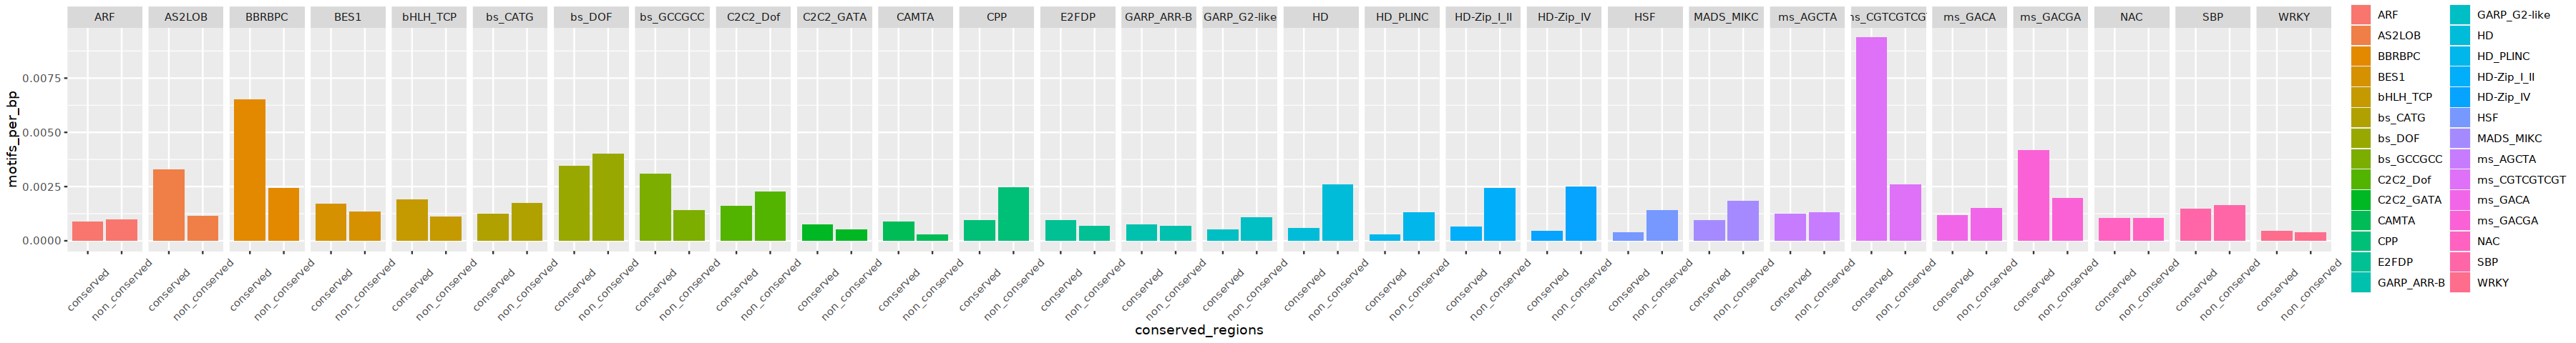

In [264]:
library(plyranges)
## calculate information about length, as well as number of occurences in each class
total_bp_by_class <- merged_regions %>% 
    group_by(conserved_regions) %>%
    summarize(total_width = sum(width))

## Calculate the Number of TFs occuring in Each Class

tf_counts <- as.data.frame(zm_granges_list) %>% 
    dplyr::group_by(TF_ID, conserved_regions) %>% 
    dplyr::summarise(TF_count = n()) %>% 
    ungroup() %>% 
    ## Nasty, had to convert to DF before summarizing since it was a plyrange object
    left_join(., as.data.frame(total_bp_by_class), by = "conserved_regions") %>% 
    dplyr::mutate(motifs_per_bp = TF_count/total_width)

options(repr.plot.width=30, repr.plot.height=4)
ggplot(tf_counts, aes(x = conserved_regions, y = motifs_per_bp, fill = TF_ID)) +
    geom_bar(stat="identity") +
    facet_grid(.~TF_ID, scales = "free") +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5))


In [253]:


# # get peak sequences, we'll need this later
# zm_peak_seqs_annotated <- getSeq(BSgenome.Zm_B73, all_ms_acrs) # <2s


# # exclude peaks with any N's, to avoid warnings further down
# hasNs    <- (alphabetFrequency(zm_peak_seqs_annotated)[,"N"]>0)
# addmargins(table(hasNs)) # => only drops 5 sequences

# zm_peak_seqs_annotated <- zm_peak_seqs_annotated[!hasNs]
# zm_peak_seqs_annotated  <- zm_peak_seqs_annotated[!hasNs]



# library(monaLisa)
# # we first have to set up a way to define the "common" state as the background
# all_ms_acrs$conserved_regions <- setZeroBin(factor(all_ms_acrs$conserved_regions), "nonConserved")

# ## Testing if the ACR class if signifigant in any way

# # now run monaLisa
# system.time( check_res_acr_type <- calcBinnedMotifEnrR(
#   zm_peak_seqs_annotated,
#   bins = all_ms_acrs$conserved_regions,
#   pwmL = pw_matrix_list_converted,
#   background = "otherBins", 
#   min.score = 3,
#   BPPARAM =  BiocParallel::MulticoreParam(16)
# ) ) # ~40s on my laptop

# check_res_acr_type

# # reformat the results for convenience
# ora_res2_consider_acr_type <- cbind(
#   rowData(check_res_acr_type)[,c("motif.id","motif.name")],
#   2^assay(check_res_acr_type, "log2enr")[,c("Conserved","nonConserved")],  # convert to OR
#   10^(-1 * assay(check_res_acr_type, "negLog10Padj")[,c("Conserved","nonConserved")]), # convert to p-val
#   10^(-1 * assay(check_res_acr_type, "negLog10P")[,c("Conserved","nonConserved")]) # convert to p-val
# ) 
# colnames(ora_res2_consider_acr_type)[3:8] <- c("OR.Cons", "OR.NonCon", 
#                              "fdr.Cons", "fdr.NonCon", 
#                              "pval.Cons", "pval.NonCon")


# ### Yuuuuup - very nice, aligns with expectations
# x <- as_tibble(ora_res2_consider_acr_type) 
# x


In [254]:
#Generate an Index Annotation name for later usage. Will be used because we need to rip these to annotate the Granges objects
#later
extractIDDataFrame <- function(pwMatrixList) {
  ids <- sapply(pwMatrixList@listData, function(item) item@ID)
  ids <- gsub("chr", "", ids, fixed = TRUE)
  indices <- seq_along(ids)
  
  data.frame(group = indices, TF_ID = ids)
}
motif_id_index <- extractIDDataFrame(pw_matrix_list_converted)

                
# run: 30k sequences, 100 motifs
system.time(
  motif_matches_zm <- matchMotifs(
    pw_matrix_list_converted, 
    all_ms_acrs, 
      genome = BSgenome.Zm_B73, 
    p.cutoff = .001, # using a stringent p-value
    out="positions"
))  # <10s on my laptop

motif_IDs <- motif_id_index$TF_ID
zm_granges_list <- motif_matches_zm
# Annotate each GRanges object in the list with the corresponding TF ID
for (i in seq_along(zm_granges_list)) {
    zm_granges_list[[i]]$TF_ID <- motif_IDs[i]
    
    overlaps <- findOverlaps(zm_granges_list[[i]] , all_ms_acrs)
    ids <- all_ms_acrs$acr_id[subjectHits(overlaps)]
    zm_granges_list[[i]]$acr_id <- ids[queryHits(overlaps)]
}


   user  system elapsed 
  0.430   0.000   0.431 

In [255]:
zm_acrs_TFs <- as_tibble(as.data.frame(zm_granges_list)) %>% 
    tidyr::separate(acr_id, into = c("acr", "acr_cell_type_specific_class"), sep = ";") %>%
    dplyr::mutate(acr_cell_type_specific_class = case_when(acr_cell_type_specific_class == "bundle_sheath,procambial_meristem" ~ "bundle_sheath",
                                                          acr_cell_type_specific_class == "bundle_sheath,procambium" ~ "bundle_sheath", 
                                                          TRUE ~ acr_cell_type_specific_class)) %>% 
    left_join(., combined_acrs_marker_info_subset, by = c("acr", "acr_cell_type_specific_class")) %>% 
    mutate(locus = case_when(is.na(locus) == TRUE ~ "None",
                            TRUE ~ locus),
           gene_family = case_when(is.na(gene_family) == TRUE ~ "None",
                            TRUE ~ locus),
           type = case_when(is.na(type) == TRUE ~ "None",
                            TRUE ~ type),
          )

ERROR: [1m[33mError[39m in `tidyr::separate()`:[22m
[1mCaused by error:[22m
[33m![39m object 'acr_id' not found


In [94]:

ora_res <- list()
system.time({
    for (motif_id in unique(zm_acrs_TFs$TF_ID)) {
        subsample <- zm_acrs_TFs %>% 
            dplyr::filter(TF_ID == motif_id) # Filter for each motif_id

        xt <- xtabs(~ type + acr_cell_type_specific_class, data = subsample)

        # Replace zeros with ones in the contingency table
        xt <- apply(xt, c(1, 2), function(x) ifelse(x == 0, 1, x))
        
        print(xt[c("mesophyll", "None"), c("mesophyll", "broadly_accessible")])
        ft.ms <- fisher.test(xt[c("mesophyll", "None"), c("mesophyll", "broadly_accessible")], alternative = "greater")
        ft.bs <- fisher.test(xt[c("bundle_sheath", "None"), c("bundle_sheath", "broadly_accessible")], alternative = "greater")
        ft.bs_vs_ms <- fisher.test(xt[c("bundle_sheath", "mesophyll"), c("bundle_sheath", "mesophyll")], alternative = "greater")
        ft.ms_vs_bs <- fisher.test(xt[c("mesophyll", "bundle_sheath"), c("mesophyll", "bundle_sheath")], alternative = "greater")

        ora_res[[motif_id]] <- data.frame(
            "Motif.ID" = motif_id,
            "OR.ms" = unname(ft.ms$estimate), "pv.ms" = ft.ms$p.value,
            "OR.bs" = unname(ft.bs$estimate), "pv.bs" = ft.bs$p.value,
            "OR.bs_vs_ms" = unname(ft.bs_vs_ms$estimate), "pv.bs_vs_ms" = ft.bs_vs_ms$p.value,
            "OR.ms_vs_bs" = unname(ft.ms_vs_bs$estimate), "pv.ms_vs_bs" = ft.ms_vs_bs$p.value
        )
    }
})


ora_res <- as.data.frame(do.call("rbind",ora_res))
rownames(ora_res) <- NULL

# adjust p-values for multiple testing
ora_res$fdr.bs <- p.adjust(ora_res$pv.bs, method="BH")
ora_res$fdr.ms   <- p.adjust(ora_res$pv.ms, method="BH") 
ora_res$fdr.bs_vs_ms   <- p.adjust(ora_res$pv.bs_vs_ms, method="BH") 
ora_res$fdr.ms_vs_bs   <- p.adjust(ora_res$pv.ms_vs_bs, method="BH") 



ERROR: Error in eval(expr, envir, enclos): object 'zm_granges_list' not found
